In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from tensorflow import keras


In [2]:
print(tf.__version__)


2.3.1


In [3]:
import pathlib
#https://cdn-144.anonfiles.com/J8c8S3s0p4/935d48c2-1606216539/data.tar.gz
data = r"C:\Users\tobia\Samlet CNN\data"
data_dir = pathlib.Path(data)
type(data_dir)


pathlib.WindowsPath

In [4]:
image_count = len(list(data_dir.glob('*/*/*.png')))
print(image_count)

35886


In [5]:
#Train
train_ds = tf.data.Dataset.list_files(str(data_dir/'train/*/*'), shuffle=False)
train_ds = train_ds.shuffle(image_count, reshuffle_each_iteration=False)
#Val
val_ds = tf.data.Dataset.list_files(str(data_dir/'val/*/*'), shuffle=False)
val_ds = val_ds.shuffle(image_count, reshuffle_each_iteration=False)

print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())


28709
3589


In [6]:
for f in train_ds.take(5):
    print(f.numpy())

b'C:\\Users\\tobia\\Samlet CNN\\data\\train\\2\\5670.png'
b'C:\\Users\\tobia\\Samlet CNN\\data\\train\\3\\26922.png'
b'C:\\Users\\tobia\\Samlet CNN\\data\\train\\3\\20005.png'
b'C:\\Users\\tobia\\Samlet CNN\\data\\train\\3\\5673.png'
b'C:\\Users\\tobia\\Samlet CNN\\data\\train\\4\\2868.png'


In [7]:
class_names = np.array(sorted([item.name for item in data_dir.glob('train/*') if item.name != "LICENSE.txt"]))
print(class_names)

['0' '1' '2' '3' '4' '5' '6']


In [8]:
batch_size = 32
img_height = 48
img_width = 48

In [9]:
def visualize(original, augmented):
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original)

    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(augmented)

In [10]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [11]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [12]:
def process_path(file_path):
    label = get_label(file_path)
  # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [13]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [14]:
print(val_ds)

<ParallelMapDataset shapes: ((48, 48, 3), ()), types: (tf.float32, tf.int64)>


Image shape:  (48, 48, 3)
Label:  2


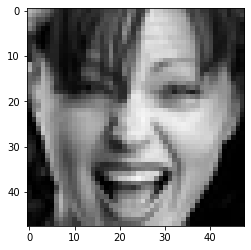

In [15]:
for image, label in train_ds.take(1):
    plt.imshow(image.numpy().astype("uint8"))
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

In [16]:
def resize_and_rescale(image, label):
    #image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [img_height, img_width])
    #image = (image/ 255.0)
    #image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
    return image, label


Image shape:  (48, 48, 3)
Label:  2
<ParallelMapDataset shapes: ((48, 48, 3), ()), types: (tf.float32, tf.int64)>
<PrefetchDataset shapes: ((None, 48, 48, 3), (None,)), types: (tf.float32, tf.int64)>


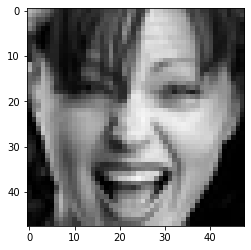

In [17]:
def augment(image,label):
    random_number = random.uniform(0.1,0.8)
    image, label = resize_and_rescale(image, label)
    # Add 6 pixels of padding
    image = tf.image.resize_with_crop_or_pad(image, img_height + 6, img_width + 6) 
    # Random crop back to the original size
    image = tf.image.random_crop(image, size=[img_height, img_width, 3])
    image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
    #image = tf.clip_by_value(image, 0, 1)
    image = tf.image.rot90(image, k=1, name=None)
    return image, label
def augmentWithBatch(image_batch, label_batch):
    image = image_batch[1]
    label = label_batch[1]
    random_number = random.uniform(0.1,0.8)
    image, label = resize_and_rescale(image,label)
    # Add 6 pixels of padding
    image = tf.image.resize_with_crop_or_pad(image, img_height + 6, img_width + 6) 
    # Random crop back to the original size
    image = tf.image.random_crop(image, size=[img_height, img_width, 3])
    image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
    #image = tf.clip_by_value(image, 0, 1)
    image = tf.image.rot90(image, k=1, name=None)
    return image_batch, label_batch

for image, label in train_ds.take(1):
    plt.imshow(image.numpy().astype("uint8"))
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    print(train_ds)
    
train_ds = (
    train_ds
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)
print(train_ds)

val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)
train_ds = (
    train_ds
    .shuffle(1000)
    .map(augmentWithBatch, num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
)

    

In [18]:

'''def configure_for_performance(ds):
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)'''

'def configure_for_performance(ds):\n    AUTOTUNE = tf.data.experimental.AUTOTUNE\n    ds = ds.cache()\n    ds = ds.shuffle(buffer_size=1000)\n    ds = ds.batch(batch_size)\n    ds = ds.prefetch(buffer_size=AUTOTUNE)\n    return ds\ntrain_ds = configure_for_performance(train_ds)\nval_ds = configure_for_performance(val_ds)'

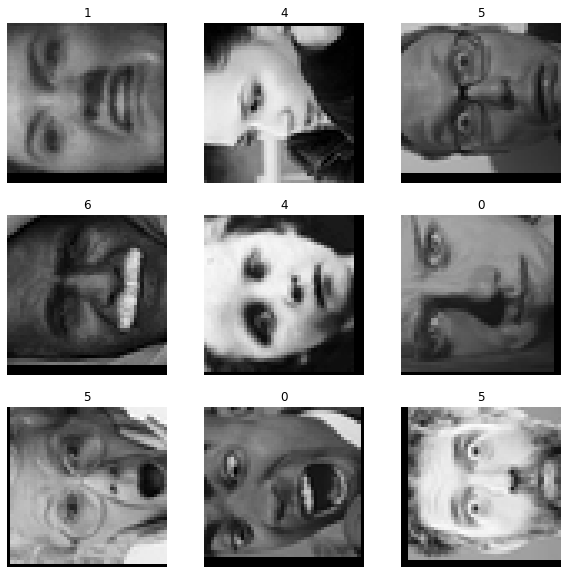

In [19]:
image_batch, label_batch = next(iter(train_ds))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")


numpy.ndarray

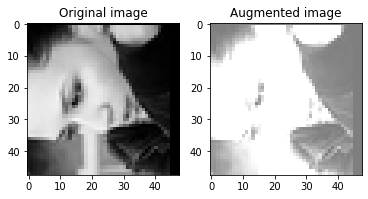

In [20]:
image = image_batch[1].numpy().astype("uint8")
flipped = tf.image.adjust_brightness(image,0.5)
visualize(image, flipped)
type(image)

In [21]:
class CustomCallback(keras.callbacks.Callback):
   
    def on_epoch_end(self, epoch, logs=None):
        train_ds= train_ds.map(augment, num_parallel_calls=AUTOTUNE)
        image = image_batch[1].numpy().astype("uint8")
        plt.imshow(image)


In [22]:
def visualize2(original):
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    image = colorImage(original)
    plt.imshow(image)

In [23]:
def flipImage(image):
    flipped = tf.image.flip_left_right(image)
    
def colorImage(image):
    image = tf.image.adjust_brightness(image,0.5)
    return image

In [24]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

num_classes = 7

cnn = tf.keras.models.Sequential([
layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[48, 48, 3]),
layers.MaxPool2D(pool_size=2, strides=2),
layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
layers.MaxPool2D(pool_size=2, strides=2),
layers.Flatten(),
layers.Dense(units=128, activation='relu'),
layers.Dense(units=7)
])

cnn.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])



In [25]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

def loss(cnn, x, y, training):
  # training=training is needed only if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  y_ = cnn(x, training=training)

  return loss_object(y_true=y, y_pred=y_)


l = loss(cnn, image_batch, label_batch, training=False)
print("Loss test: {}".format(l))

Loss test: 107.93099975585938


In [26]:
n_epoch = 20
train_ds = (
            train_ds
            .reshape(48,48,3)
           )
train_ds = (
            train_ds
            .shuffle(1000)
            .map(augment, num_parallel_calls=AUTOTUNE)
            .prefetch(AUTOTUNE)
         )
for i in range(n_epoch):
    try:
        cnn.fit(train_ds, validation_data = val_ds, epochs = 1)
        
        train_ds = (
            train_ds
            .shuffle(1000)
            .map(augment, num_parallel_calls=AUTOTUNE)
            .prefetch(AUTOTUNE)
         )
    except ValueError:
        print(train_ds)
        

AttributeError: 'PrefetchDataset' object has no attribute 'reshape'

In [ ]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

In [ ]:
'''
trænings kode som ikke skal bruges

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
ge_batch,
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)
'''

In [ ]:
import numpy as np
from keras.preprocessing import image
test_image = image.load_img(r'C:\Users\tobia\Samlet CNN\data\billede\face.jpg', target_size = (48, 48))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = cnn.predict(test_image)
print(result)
train_ds.class_indices